In [2]:
import matplotlib.pyplot as plt
import skimage.filters as f
from skimage.color import rgb2gray
from skimage import exposure
from scipy.signal import convolve2d
from skimage import morphology as m
import numpy as np

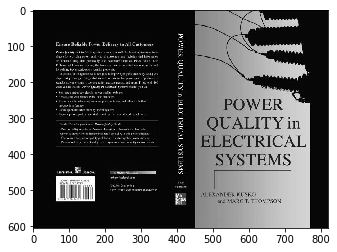

In [18]:
img = plt.imread("../books/PowerQualityBookCover.jpg")
plt.gray()
plt.imshow(rgb2gray(img))

(605, 820, 3)


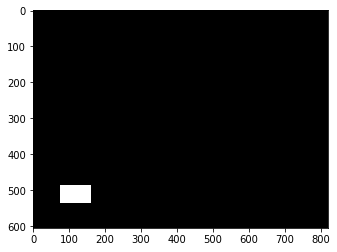

In [28]:
def FindBarcode(img):
    imgG = rgb2gray(img) #convert colour image to gray-scale if colour
    imgV = f.sobel_v(imgG) #vertical gradient image
    imgH = f.sobel_h(imgG) #horizontal gradient image
    imgGradient = np.abs(imgH- imgV) #image with high horizontal gradient and low vertical gradient

    filterSize = (int)(max(img.shape[0], img.shape[1])/100) #get approximate filter size
        #blur image with box filter and zero padding
    blurred = exposure.rescale_intensity(convolve2d(imgGradient, m.square(filterSize)/filterSize**2, mode="same"))
    n = f.threshold_otsu(imgGradient) #obtain threshold from gradient
    bar = exposure.rescale_intensity(blurred) >= n #threshold on blurred image

    SE = np.ones((5,5))
    b = m.closing(bar, SE) #close any gaps in foreground
    
    count = 4
    #removing non wide elements
    for i in range(count):
        b = m.erosion(b, np.ones((1,21)))
    for i in range(count):
        b = m.dilation(b, np.ones((1,21)))
    #removing non tall elements
    for i in range(count):
        b = m.erosion(b, np.ones((13,1)))
    for i in range(count):
        b = m.dilation(b, np.ones((13,1)))
    plt.imshow(b)
    return b

b = FindBarcode(img)
plt.imsave("../barcodeLocation.jpg", b)
print(img.shape)

0.0 1.0


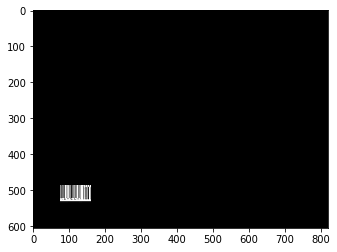

In [29]:
output = b * rgb2gray(img)
print(np.min(output), np.max(output))
plt.imshow(output)

485 534 74 161


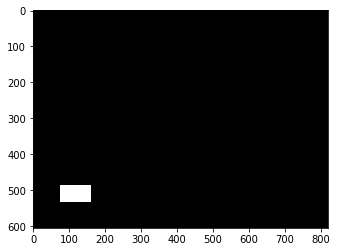

In [30]:
def ExtractBounds(I):
    positions = np.nonzero(I)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()
    width = right - left
    height = bottom - top
    x = (int)(right - width/2)
    y = (int)(bottom - height/2)
    s = np.ones((height, width)) #structuring element
    h = np.zeros((b.shape[0], b.shape[1])) #black image
    print(top, bottom, left, right)
    h[y][x] = 1 #bar-code location
    detect = m.dilation(h, s) #bar-code mask placement
    return detect, [top,bottom], [left,right]
d = ExtractBounds(b)
plt.imshow(d[0])
plt.imsave("../fullBarcodeLocation.jpg", d[0])

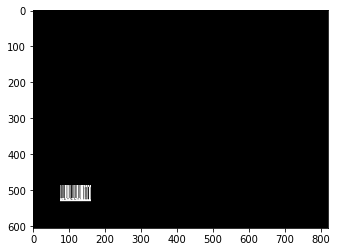

In [31]:
imgOut = d[0] * rgb2gray(img)
plt.imshow(imgOut)

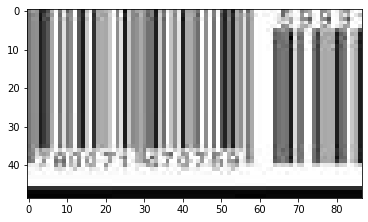

In [32]:
barcodeOnly = imgOut[d[1][0]:d[1][1], d[2][0]:d[2][1]]
plt.imshow(barcodeOnly)

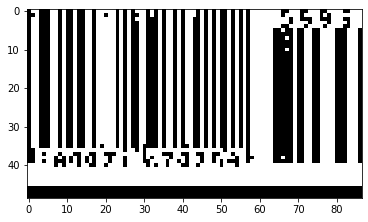

In [33]:
br = f.unsharp_mask(barcodeOnly)
T = f.threshold_otsu(br)
br = br >= T #extract white only
plt.imshow(br)

0 45 0 86


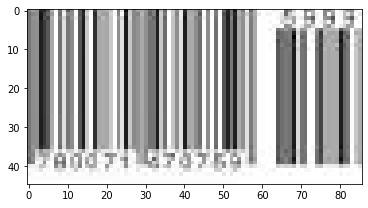

In [34]:
dd = ExtractBounds(br) #extract white only
final = barcodeOnly[dd[1][0]:dd[1][1],dd[2][0]:dd[2][1]]
plt.imshow(final)

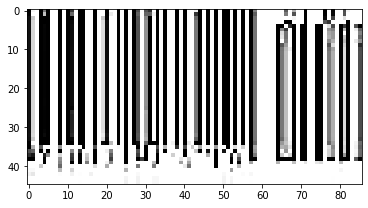

In [35]:
finall = m.dilation(final, np.ones(((int)(final.shape[0]/2),1)))
finall = m.erosion(finall, np.ones(((int)(final.shape[0]/2),1))) #extract bar information

for i in range(4):
    finall = f.unsharp_mask(finall) #extract gradient information as bar information
plt.imshow(finall)

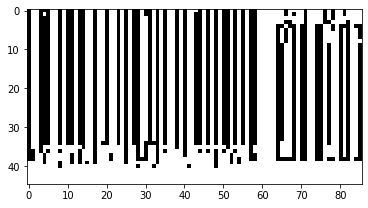

In [36]:
TH = f.threshold_otsu(finall)
T = f.threshold_otsu(final)
plt.imshow(finall > TH)

0 2


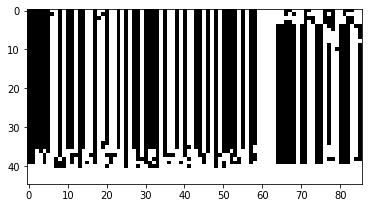

In [37]:
overlay = np.add((finall > TH).astype(int),(final > T).astype(int)) #overlay the text with the bars
print(np.min(overlay), np.max(overlay))
plt.imshow(overlay > 1)

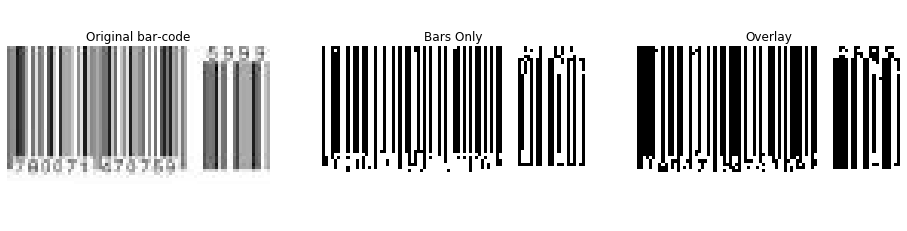

In [38]:
fig, axs = plt.subplots(1,3,figsize=(16,4))
[axi.set_axis_off() for axi in axs.ravel()]
axs[0] = fig.add_subplot(1,3,1)
axs[0].set_title("Original bar-code")
axs[0].imshow(final)
plt.axis('off')
axs[1] = fig.add_subplot(1,3,2)
axs[1].set_title("Bars Only")
axs[1].imshow(finall > TH)
plt.axis('off')
axs[2] = fig.add_subplot(1,3,3)
axs[2].set_title("Overlay")
axs[2].imshow(overlay > 1)
plt.axis('off')
fig.savefig("../bar-codes.jpg")